Optical field calculation using the Fourier Modal Method
====

In [110]:
%reset

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, linalg, integrate

# Part 1. Eigenmode calculation

In [24]:
N=25                                    # summation limits
M=2*N+1                                 # Total Number of plane wave terms included in expansion

l = 0.633                               # work wavelength in µm
thetaDeg = 0
theta = thetaDeg * ((2*np.pi)/360)      # Angle of incidence (radians)

eps1 = 1
sqrteps2 = 1.5
eps2=sqrteps2**2
n1=np.sqrt(eps1)
n2=sqrteps2

k0 = 2*np.pi/l                          # k vector in layer 1 (air)
k1=k0*np.sqrt(eps1)
kx = k1*np.sin(theta)

Lambda = 0.400      # µm
f = 0.32

# constants
G = 2*np.pi/Lambda

# build A matrix
A = np.eye(M)
for i in range(M):
        A[i ,i] = ((-N+i)*G+kx)**2


In [29]:
def complex_quadrature(func, a, b, **kwargs):
    def real_func(x):
        return np.real(func(x))
    def imag_func(x):
        return np.imag(func(x))
    real_integral = integrate.quad(real_func, a, b, limit=100, **kwargs)
    imag_integral = integrate.quad(imag_func, a, b, limit=100, **kwargs)
    return real_integral[0] + 1j*imag_integral[0]

B = np.zeros((M, M), dtype=np.complex_)
for i in range(M):
    for j in range(M):
        func = lambda x: (eps1*np.heaviside(x-f*Lambda, 0)+eps2*np.heaviside(f*Lambda-x, 0)) * np.exp(-1j*(i-j)*G*x)
        B[i,j] = (1/Lambda) * complex_quadrature(func, 0, Lambda)


In [33]:
EigPb = -A + (k0**2)*B

eigenValues, eigenVectors = linalg.eig(EigPb)

# sort 'em all
idx = eigenValues.argsort()[::-1]   
eigvals = eigenValues[idx]
eigvecs = eigenVectors[:,idx]

In [35]:
np.real(eigvals[0:3])

array([ 148.19098876,  -99.07456265, -124.72129464])

In [44]:
# normalization
for i in range(M):
    C = np.sqrt(eigvals[i]) * np.sum(np.abs(eigvecs[i])**2)*Lambda
    eigvecs[i] = -eigvecs[i]*1/np.sqrt(C)

x = np.arange(0, Lambda, 0.001)    # µm

E2x = np.zeros((len(x),M), dtype=np.complex_)

for o in range(len(x)):
    for n in range(-N, N):
        E2x[o] = E2x[o] + eigvecs[n+N] * np.exp(1j*(kx+n*G)*x[o])

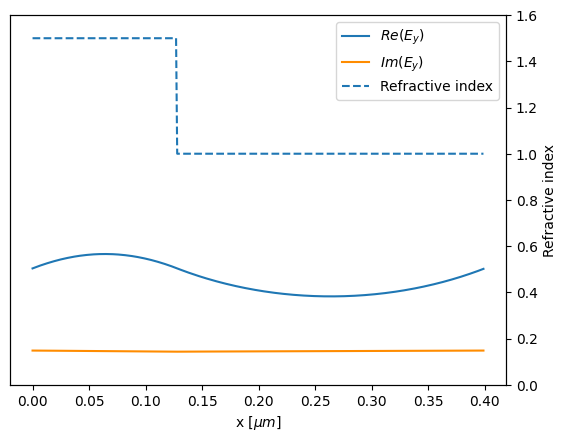

In [66]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(x, np.real(E2x[:, 0]), label="$Re(E_y)$")
lns2 = ax1.plot(x, np.imag(E2x[:, 0]), color="darkorange", label="$Im(E_y)$")
lns3 = ax2.plot(x, n1 + (n2-n1)*np.heaviside(f*Lambda-x, 0), linestyle="--", label="Refractive index")

ax1.set_xlabel("x [$\mu m$]")
ax2.set_ylabel("Refractive index")

ax1.set_yticks([])
ax1.set_ylim([-0.05, .5])
ax2.set_ylim([0, 1.6])

# build legend
lns = lns1+lns2+lns3
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')
plt.show()

# Part 2. Reflection and transmission at an interface

In [111]:
# set up constants and parameters for the Air-grating-substrate setup

N=25                       # summation limits
M=2*N+1                    # Total Number of plane wave terms included in expansion
spatialresolution=250

L=385e-9                   # height of substrate (layer 2) in m
wavelength=633e-9          # wavelength of light in m
thetaDegree=0              # angle of incidence in degrees 

theta=thetaDegree*2*np.pi/360   # Angle of incidence in radians

epsilon1=1
epsilon2=1.5**2

n1=np.sqrt(epsilon1)
n2=np.sqrt(epsilon2)

k1=n1*2*np.pi/wavelength    # k vector in layer 1 (air)
k0=k1                       # define k0 same as in air
k3=n2*(2*np.pi)/wavelength  # k vector in layer 3 (glass substrate)
GratePeriod=400e-9          # grating period, the periodicity in the x-direction in layer 2
f=0.32                      # filling factor a/Lamda
a=GratePeriod*f             # the thickness of each grate-layer

G=2*np.pi/GratePeriod
GrateSpacing=GratePeriod-a

ztop12=GratePeriod/2        # top of computational domain
zbot12=-GratePeriod/2       # bottom of computational domain

In [112]:
# Construct the matrices
kx=k1*np.sin(theta)

# reallocate matrices
A=np.zeros((M,M), dtype=np.complex_)
B=np.zeros((M,M), dtype=np.complex_)

Nvec=np.linspace(-N,N,M)
Nvec2=np.linspace(-2*N,2*N,4*N+1)
A=np.diag(Nvec*G+kx)**2

In [113]:
def sortem(eigenVectors, eigenValues):
    idx = eigenValues.argsort()[::-1]   
    return eigenVectors[:,idx], eigenValues[idx]

eps2vec = np.zeros(len(Nvec2), dtype=np.complex_)
for j in range(len(Nvec2)):
    eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )

eps2vec[M-1] = (epsilon2*a+epsilon1*GrateSpacing)/GratePeriod

for j in range(M):
    for u in range(M):
      B[j,u]=eps2vec[M+j-u-1]

eigmat1=-A+(k0**2)*B
betasquared1, eigvecunnorm1 = linalg.eig(eigmat1)
betasquared1 = np.real(betasquared1)
eigvecunnorm, betasquared=sortem(eigvecunnorm1, betasquared1)

C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\165988908.py:7: RuntimeWarning: divide by zero encountered in divide
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )
C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\165988908.py:7: RuntimeWarning: invalid value encountered in divide
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )
C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\165988908.py:7: RuntimeWarning: invalid value encountered in scalar multiply
  eps2vec[j]=(1/GratePeriod) * (np.divide(1, (-1j*G*Nvec2[j]))) * ( epsilon2*(np.exp(-1j*Nvec2[j]*G*a) - 1) + epsilon1*(np.exp(-1j*Nvec2[j]*G*GratePeriod)-np.exp(-1j*Nvec2[j]*G*a)) )


In [115]:
# Determine the normalization constant
C = np.zeros(M, dtype=np.complex_)
eigvecnorm = np.zeros(eigvecunnorm.shape, dtype=np.complex_)
for j in range(M):
    C[j]=np.emath.sqrt(betasquared[j])*GratePeriod*(np.linalg.norm(eigvecunnorm[j])**2)
    eigvecnorm[j]=np.divide(1, np.emath.sqrt(C[j]))*eigvecunnorm[j]

In [116]:
# Now we find the E-field in the y-direction

xvec=np.linspace(0,GratePeriod,spatialresolution)
zvec12=np.linspace(zbot12,ztop12,spatialresolution)
# this is the calculation of the fundamental mode - we can also calculate
# the rest, but it is computationally heavy

u1matunsorted=np.diag(np.ones(M, dtype=np.complex_))
beta1unsorted=np.emath.sqrt(epsilon1*(k0**2)*np.ones(M)-(kx*np.ones(M)+G*Nvec)**2)

u1mat, beta1vec=sortem(u1matunsorted, (beta1unsorted**2))
beta1=np.emath.sqrt(beta1vec)

for j in range(M):
    C[j]=np.emath.sqrt(beta1vec[j])*GratePeriod*(np.linalg.norm(u1mat[j])**2)
    u1mat[j]=np.divide(1, np.emath.sqrt(C[j]))*u1mat[j]


In [122]:
u3matunsorted=np.diag(np.ones(M, dtype=np.complex_))
beta3unsorted=np.emath.sqrt(epsilon2*(k0**2)*np.ones(M)-(kx*np.ones(M)+G*Nvec)**2)

u3mat, beta3vec=sortem(u3matunsorted,(beta3unsorted**2))
beta3=np.emath.sqrt(beta3vec)

for j in range(M):
    C[j]=np.emath.sqrt(beta3vec[j])*GratePeriod*(np.linalg.norm(u3mat[j])**2)
    u3mat[j]=np.divide(1, np.emath.sqrt(C[j]))*u3mat[j]

Ey2fundamental = np.zeros((spatialresolution, 1), dtype=np.complex_)
Ey1full = np.zeros((spatialresolution, M), dtype=np.complex_)
Ey2full = np.zeros((spatialresolution, M), dtype=np.complex_)
Ey3full = np.zeros((spatialresolution, M), dtype=np.complex_)
for j in range(spatialresolution):
    Ey2fundamental[j]=eigvecnorm[:, 0].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M,1)*G)*xvec[j])
    for n in range(M):     # Compute the full set
        Ey2full[j,n]=eigvecnorm[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
        Ey1full[j,n]=u1mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
        Ey3full[j,n]=u3mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])

# Here we find the phase that will make the fundamental mode purely real
FundamentalRealPhase=np.arctan(np.imag(Ey2fundamental[0])/np.real(Ey2fundamental[0]))
Ey2fundamentalreal=Ey2fundamental*np.exp(-1j*FundamentalRealPhase)

C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\2944913722.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ey2full[j,n]=eigvecnorm[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\2944913722.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Ey1full[j,n]=u1mat[:, n].reshape(1, M) @ np.exp(1j*(kx*np.ones((M,1))+Nvec.reshape(M, 1)*G)*xvec[j])
C:\Users\amcar\AppData\Local\Temp\ipykernel_127488\2944913722.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single el

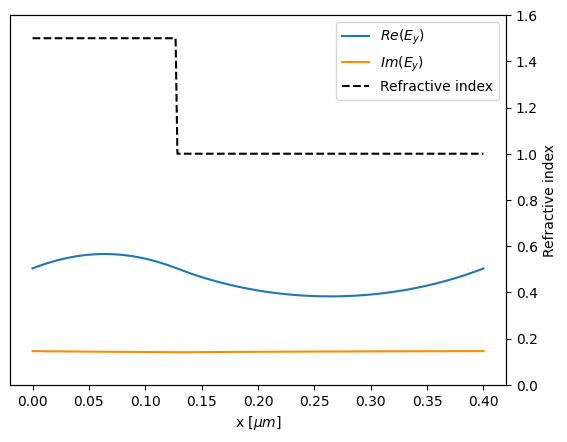

In [123]:
epsvec=np.concatenate([(epsilon2*np.ones(int(f*spatialresolution))), (epsilon1*np.ones(int(spatialresolution-f*spatialresolution)))])

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

lns1 = ax1.plot(xvec*(10**6), np.real(Ey2fundamentalreal), label="$Re(E_y)$")
lns2 = ax1.plot(xvec*(10**6), np.imag(Ey2fundamentalreal), color="darkorange", label="$Im(E_y)$")
lns3 = ax2.plot(xvec*(10**6), np.sqrt(epsvec), color="black", linestyle="--", label="Refractive index")

ax1.set_xlabel("x [$\mu m$]")
ax2.set_ylabel("Refractive index")

ax1.set_yticks([])
ax1.set_ylim([-0.05, .5])
ax2.set_ylim([0, 1.6])

# build legend
lns = lns1+lns2+lns3
labs = [ln.get_label() for ln in lns]
ax1.legend(lns, labs, loc='upper right')
plt.show()

In [ ]:
u2mat=eigvecnorm
beta2=np.emath.sqrt(betasquared)

tmat12=2*inv(inv(u1mat)*u2mat+inv(u1mat*diag(beta1))*(u2mat*sqrt(betasquared)))
tmat21=2*inv(inv(u2mat)*u1mat+inv(u2mat*sqrt(betasquared))*(u1mat*diag(beta1)))

rmat12=1/2*(inv(u1mat)*u2mat - inv(u1mat*diag(beta1))*(u2mat*sqrt(betasquared)))*tmat12

In [67]:
u1matunsorted = np.diag(np.ones(M))
u1matunsorted

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [68]:
def sortem(eigenVectors, eigenValues):
    idx = eigenValues.argsort()[::-1]   
    return eigenVectors[:,idx], eigenValues[idx]

u2mat = eigvecs
beta2 = np.sqrt(eigvals)

u1matunsorted = np.diag(np.ones(M))
beta1unsorted = np.zeros((M, 1))

for n in range(-N, N):
    beta1unsorted[n] = np.sqrt(eps1*(k0**2) - ((kx+n*G)**2))

u1mat, beta1vec = sortem(u1matunsorted, beta1unsorted**2)
beta1 = np.sqrt(beta1vec)

# normalization
for i in range(M):
    C = np.sqrt(beta1vec[i]) * np.sum(np.abs(u1mat[i])**2)*Lambda
    u1mat[i] = -u1mat[i]*1/np.sqrt(C)


tmat12 = 2*np.linalg.pinv(np.linalg.pinv(u1mat)@u2mat+np.linalg.pinv(u1mat@beta1)@(u2mat @ beta2))

C:\Users\amcar\AppData\Local\Temp\ipykernel_84500\614379456.py:12: RuntimeWarning: invalid value encountered in sqrt
  beta1unsorted[n] = np.sqrt(eps1*(k0**2) - ((kx+n*G)**2))
C:\Users\amcar\AppData\Local\Temp\ipykernel_84500\614379456.py:20: RuntimeWarning: divide by zero encountered in divide
  u1mat[i] = -u1mat[i]*1/np.sqrt(C)
C:\Users\amcar\AppData\Local\Temp\ipykernel_84500\614379456.py:20: RuntimeWarning: invalid value encountered in divide
  u1mat[i] = -u1mat[i]*1/np.sqrt(C)


LinAlgError: SVD did not converge